### Following to Data discription page, there are 11 columns.

1. AggregationMethod: Aggregation period used to compute this metric

2. Date: Date Traffic volume measured, in format YYYY-MM-DD.

3. Version: Version of this dataset

4. AirportName: Name of airport

5. PercentOfBaseline: Proportion of trips on this date as compared to Avg number of trips on the same day of week in baseline period i.e 1st February 2020 - 15th March 2020

6. Centroid: Geography representing centroid of the Airport polygon

7. City: City within which the Airport is located

8. State: State within which the Airport is located

9. ISO_3166_2: ISO-3166-2 code representing Country and Subdivision

10. Country: Country within which the Airport is located

11. Geography: Polygon of the Airport that is used to compute this metric

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the path to your CSV file
file_path = '/content/drive/My Drive/Data Visualisation in Python/covid_impact_on_airport_traffic.csv'

In [ ]:
#Importing library
import pandas as pd

covid_impact_on_airport_traffic = pd.read_csv(file_path)

In [ ]:
#Checking top 5 entries
covid_impact_on_airport_traffic.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


In [ ]:
covid_impact_on_airport_traffic.shape

(7247, 11)

# Data Preprocessing

In [ ]:
pip install geoplot

# Processed Data

In [ ]:
from datetime import date
import os

import geopandas as gpd
import geoplot as gplt
import folium
import mapclassify
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import re
import seaborn as sns
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon

In [ ]:
covid_impact_on_airport_traffic["Date"] = covid_impact_on_airport_traffic["Date"].map(lambda x: date.fromisoformat(x))

And I'll create "weekday" columns. date.weekday() returns 0 for Monday and 6 for Sunday.

With list of Weekday string, we can get weekday columns which has each weekday string.

In [ ]:
covid_impact_on_airport_traffic["weekday"] = covid_impact_on_airport_traffic["Date"].map(lambda x: x.weekday())
w_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
covid_impact_on_airport_traffic["weekday"] = [w_list[idx] for idx in covid_impact_on_airport_traffic["weekday"]]

Next, I'll create Latitude and longitude columns. Centroid column has Latitude and longitude data as Point object, but it seems to be string. So, I'll cut out Latitude and longitude.

In [ ]:
def cut_long(point):
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    long, _ = point[6:-1].split(" ")
    return float(long)

def cut_lat(point):
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    _, lat = point[6:-1].split(" ")
    return float(lat)

Drop unnecessary columns.

In [ ]:
covid_impact_on_airport_traffic["long"] = covid_impact_on_airport_traffic["Centroid"].map(cut_long)
covid_impact_on_airport_traffic["lat"] = covid_impact_on_airport_traffic["Centroid"].map(cut_lat)

In [ ]:
need_columns = [col for col in covid_impact_on_airport_traffic.columns if not col in ["AggregationMethod", "Version", "Centroid"]]
covid_impact_on_airport_traffic = covid_impact_on_airport_traffic[need_columns]

In [ ]:
covid_impact_on_airport_traffic.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-04-13,Kingsford Smith,29,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Mon,151.180088,-33.945977
2,2020-07-10,Kingsford Smith,54,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
3,2020-09-02,Kingsford Smith,18,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Wed,151.180088,-33.945977
4,2020-10-31,Kingsford Smith,22,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Sat,151.180088,-33.945977


# Further processing

In addition, I'll create a supplementary data frame.

First, a data frame that makes the airport name unique. We can easily see data for each airport. and I'll use it later when we plot it with folium.

In [ ]:
covid_impact_on_airport_traffic_unique = covid_impact_on_airport_traffic[~covid_impact_on_airport_traffic[["AirportName"]].duplicated()].reset_index(drop=True)
covid_impact_on_airport_traffic_unique

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-03-17,Santiago International Airport,72,Santiago,Santiago Province,CL,Chile,"POLYGON((-70.8043956756592 -33.3719683869737, ...",Tue,-70.794237,-33.390727
2,2020-04-05,Calgary International,65,Calgary,Alberta,CA-AB,Canada,"POLYGON((-113.981866836548 51.1392131913567, -...",Sun,-114.013123,51.118475
3,2020-04-20,Edmonton International,46,Leduc County,Alberta,CA-AB,Canada,"POLYGON((-113.568120002747 53.3110445425655, -...",Mon,-113.576261,53.308783
4,2020-05-15,Vancouver International,68,Richmond,British Columbia,CA-BC,Canada,"POLYGON((-123.136525154114 49.1980971490671, -...",Fri,-123.177541,49.193579
5,2020-05-27,Winnipeg International,100,Winnipeg,Manitoba,CA-MB,Canada,"POLYGON((-97.2094345092773 49.8979517850609, -...",Wed,-97.219062,49.902471
6,2020-03-29,Halifax International,32,Halifax,Nova Scotia,CA-NS,Canada,"POLYGON((-63.5266613960266 44.8984438169036, -...",Sun,-63.511672,44.883017
7,2020-04-10,Toronto Pearson,10,Mississauga,Ontario,CA-ON,Canada,"POLYGON((-79.6076846122742 43.6972621366144, -...",Fri,-79.631344,43.679352
8,2020-08-10,Hamilton International,100,Hamilton,Ontario,CA-ON,Canada,"POLYGON((-79.932746887207 43.1551600161937, -7...",Mon,-79.926693,43.172036
9,2020-09-16,Montreal Mirabel,100,Mirabel,Quebec,CA-QC,Canada,"POLYGON((-74.0895652770996 45.6856314730097, -...",Wed,-74.048380,45.681503


In [ ]:
#Next, geometry dataframe which key is airport name.
df_geometry = covid_impact_on_airport_traffic_unique[['AirportName', 'City', 'State',
                                                     'ISO_3166_2', 'Country', 'long', 'lat']]

# Plotting with Geopandas

In [ ]:
import geopandas as gpd
import geoplot as gplt

In [ ]:
#create GeoDataFrame. When create, we can create a column of Point instances by specifying "geometry" argument.
gdf = gpd.GeoDataFrame(covid_impact_on_airport_traffic_unique,
                       geometry=gpd.points_from_xy(covid_impact_on_airport_traffic_unique.long, covid_impact_on_airport_traffic_unique.lat))

In [ ]:
gdf.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat,geometry
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977,POINT (151.18009 -33.94598)
1,2020-03-17,Santiago International Airport,72,Santiago,Santiago Province,CL,Chile,"POLYGON((-70.8043956756592 -33.3719683869737, ...",Tue,-70.794237,-33.390727,POINT (-70.79424 -33.39073)
2,2020-04-05,Calgary International,65,Calgary,Alberta,CA-AB,Canada,"POLYGON((-113.981866836548 51.1392131913567, -...",Sun,-114.013123,51.118475,POINT (-114.01312 51.11848)
3,2020-04-20,Edmonton International,46,Leduc County,Alberta,CA-AB,Canada,"POLYGON((-113.568120002747 53.3110445425655, -...",Mon,-113.576261,53.308783,POINT (-113.57626 53.30878)
4,2020-05-15,Vancouver International,68,Richmond,British Columbia,CA-BC,Canada,"POLYGON((-123.136525154114 49.1980971490671, -...",Fri,-123.177541,49.193579,POINT (-123.17754 49.19358)


In [ ]:
#get world map with datasets.get_path(). By this, we can get GeoDataFrame which includes world map data

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

<ipython-input-68-f65d5ec04be3>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Text(0.5, 1.0, 'example world map')

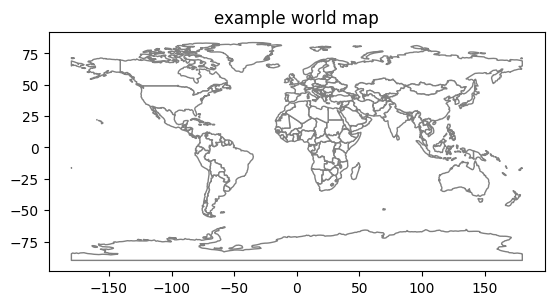

In [ ]:
#With plot(), we can plot the map.

g = world.plot(color='white', edgecolor='gray')
g.set_title("example world map")

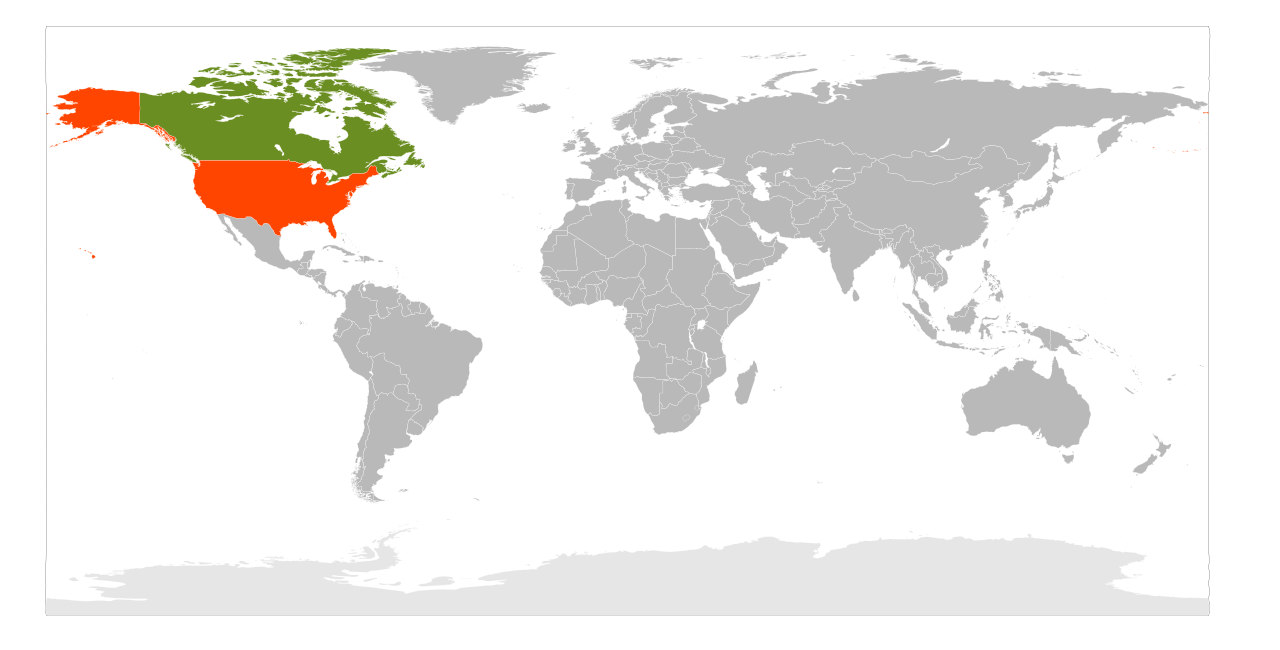

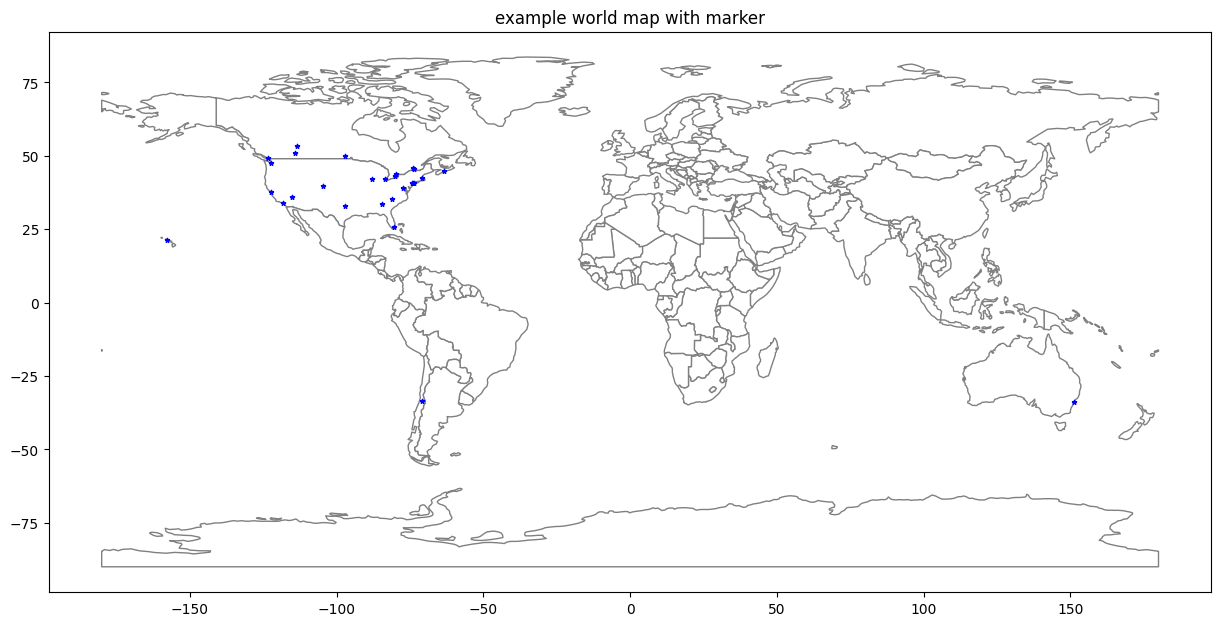

In [ ]:
#overwrite the data on world map like following

ax = world.plot(color='white', edgecolor='gray', figsize=(15, 10))

#Plot datapoints
g = gdf.plot(ax=ax, marker='*', color='blue', markersize=10)


g.set_title("example world map with marker")
plt.show()